<a href="https://colab.research.google.com/github/KorStats/skku/blob/main/(%EC%B5%9C%EC%A2%85)_kobert_nsmc_0_8_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요 라이브러리 설치

In [1]:
!pip install transformers datasets accelerate scikit-learn optuna sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install transformers

In [3]:

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import torch
import optuna
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import platform
import transformers
import joblib

In [4]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 사용할 데이터

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'Colab Notebooks'  'My Drive'   이전   졸업논문


In [6]:
import pandas as pd
df=pd.read_csv('/content/gdrive/MyDrive/졸업논문/DATA/NSMC_0.8.csv', encoding='utf-8-sig')

In [7]:
df.head(10)

,Unnamed: 0.1,Unnamed: 0,id,document,label,길이
0,0,90860,9856738,처음에 이 아이가 크리스천베일임을 알아보고 매우 깜짝놀랐다. 역시 명배우의 이름답게...,1,118
1,1,71248,6677900,우뢰매1이 Tv에서 첫방할때 아버지는 씨름을보셨다.엉엉울었다.Tv가 1대밖에 없던 ...,1,72
2,2,29358,9623874,빠른 상황전개.쉴틈없는 퍼포먼스가 영화내내 이어진다.스토리 자체가 좀 억지스럽지만 ...,1,83
3,3,83108,7326409,"스웨덴 남녀의 순수한 청춘 로맨스와 한가로운 유럽의 자연, 이들을 한층 더 격높게 ...",1,91
4,4,38018,8731170,동화를 좋아하는 동심있는 어른들을 위한 영화. 사랑이 얼마나 유치한것이지 보여준다....,1,83
5,5,78405,8025256,이게 7점대라니.. 액션영화 좋아하시는 분은 이 영화를 보고 평점 내리지 마세요 ....,1,107
6,6,53276,9793997,딱!! 배트맨답다는 느낌이 드는 영화~!! 슈퍼맨을 동네 아저씨로 바꿔놓았던 맨 오...,1,140
7,7,27957,7522981,미야자키 고로와 미야자키 하야오도 구분못하는 쓰레기들이 요기잉네 여기서 입터는 사람...,1,99
8,8,81848,8909178,서양 공포 영화는 무섭다는 생각을 안했는데 이 영화만큼은 그로테스크한 분위기와 탄탄...,1,137
9,9,90782,9416640,배우분들 연기도 좋고 어떻게 풀어나갈지 기대도 됩니다. 다들 열촬하셔서 명품 사극 ...,1,71


In [8]:
df['label'].value_counts()

,count
label,
1,5000
0,4000


In [9]:
df_test=pd.read_excel('/content/gdrive/MyDrive/졸업논문/DATA/NSMC_test.xlsx')

In [10]:
data_list = []
for q, label in zip(df['document'], df['label'])  :
    data = []
    data.append(q)
    data.append(str(label))
    data_list.append(data)

#from sklearn.model_selection import train_test_split
#dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0, shuffle=True)

train=pd.DataFrame(data_list)

data_list = []
for q, label in zip(df_test['document'], df_test['label'])  :
    data = []
    data.append(q)
    data.append(str(label))
    data_list.append(data)

test=pd.DataFrame(data_list)

train.rename(columns = {0 : 'text', 1 : 'category'}, inplace = True)
test.rename(columns = {0 : 'text', 1 : 'category'}, inplace = True)

In [11]:
train.shape

(9000, 2)

In [12]:
test.shape

(2000, 2)

# 데이터 정제

In [13]:
def clean_korean_documents(documents):
    # 텍스트 정제 (특수기호만 제거)
    for i, document in tqdm(enumerate(documents), total=len(documents), desc="Cleaning Special Characters"):
        document = re.sub(r'[^\w\sㄱ-ㅣ가-힣]', '', document)  # 특수기호만 제거, 정규 표현식
        documents[i] = document
    return documents

def remove_words_with_numbers(text):
    return ' '.join([word for word in text.split(',') if not re.search(r'\d', word)])

# 한글이 아닌 문자를 제거하는 함수
def remove_non_korean(text):
    return re.sub(r'[^ㄱ-ㅣ가-힣\s]', '', text)

In [14]:
train['text'] = clean_korean_documents(train['text'])
train['text'] = train['text'].apply(lambda x: ','.join(x.split()))
train['text'] = train['text'].apply(remove_words_with_numbers)
train['text'] = train['text'].apply(remove_non_korean)

test['text'] = clean_korean_documents(test['text'])
test['text'] = test['text'].apply(lambda x: ','.join(x.split()))
test['text'] = test['text'].apply(remove_words_with_numbers)
test['text'] = test['text'].apply(remove_non_korean)


Cleaning Special Characters: 100%|██████████| 2000/2000 [00:00<00:00, 13996.29it/s]


In [15]:
# 3. 학습 데이터와 테스트 데이터에서 필요한 열 추출 및 라벨 인코딩
X_train = train['text']
y_train = train['category']
X_test = test['text']
y_test=test['category']

# 4. 라벨 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded=label_encoder.fit_transform(y_test)
num_labels = len(label_encoder.classes_)

# KoBERT

In [16]:
# 5. KoBERT 모델을 위한 토크나이저 및 데이터셋 생성
model_name = 'monologg/kobert'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

tokenization_kobert.py:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/monologg/kobert:
- tokenization_kobert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_78b3253a26.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

In [17]:
# 텍스트를 토큰화하는 함수 정의
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

In [18]:
# 데이터셋 생성 및 토크나이즈
train_df = pd.DataFrame({'text': X_train, 'label': y_train_encoded})
test_df = pd.DataFrame({'text': X_test, 'label': y_test_encoded})
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
# PyTorch 텐서 형식으로 변환
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 5. KoBERT 모델 설정 및 학습 파라미터 최적화
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 최적의 하이퍼파라미터 찾기

In [ ]:
import optuna
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np

# `compute_metrics` 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='macro')  # F1 점수 계산
    return {'eval_f1': f1}  # 'eval_f1' 반환

# Optuna를 활용한 하이퍼파라미터 튜닝
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 샘플링
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)

    # TrainingArguments 설정
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=10,
        per_device_train_batch_size=batch_size,
        num_train_epochs=5,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        report_to="none"
    )

    # Trainer 생성
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_f1"]


# Optuna 탐색
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=5)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", study.best_params)

[I 2025-02-17 15:27:01,159] A new study created in memory with name: no-name-2a6d16b3-25f2-48e3-9702-224b6e3a8879
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.322000,0.525658,0.740625
2,0.232700,0.401529,0.842925
3,0.111700,0.542204,0.819374
4,0.072900,0.548189,0.848368
5,0.022300,0.629187,0.845121


[I 2025-02-17 16:01:06,744] Trial 0 finished with value: 0.8483680422888018 and parameters: {'learning_rate': 5.3410887999666175e-05, 'batch_size': 64, 'weight_decay': 0.009899950191395234}. Best is trial 0 with value: 0.8483680422888018.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to b

Epoch,Training Loss,Validation Loss,F1
1,0.705800,0.694837,0.333333
2,0.698400,0.694657,0.333333
3,0.697900,0.693160,0.333333
4,0.691300,0.702649,0.333333
5,0.687700,0.701386,0.333333


[I 2025-02-17 16:35:04,374] Trial 1 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.0003255996611793681, 'batch_size': 64, 'weight_decay': 0.18409141011139737}. Best is trial 0 with value: 0.8483680422888018.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be 

Epoch,Training Loss,Validation Loss,F1
1,0.699600,0.722802,0.333333
2,0.700500,0.695125,0.333333
3,0.696000,0.696241,0.333333
4,0.684100,0.697717,0.333333
5,0.692000,0.701465,0.333333


[I 2025-02-17 17:09:25,241] Trial 2 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.00016824776797590474, 'batch_size': 32, 'weight_decay': 0.28251656298706973}. Best is trial 0 with value: 0.8483680422888018.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be

Epoch,Training Loss,Validation Loss,F1
1,0.700200,0.696179,0.333333
2,0.697000,0.694237,0.333333
3,0.695800,0.693151,0.333333
4,0.686900,0.701207,0.333333
5,0.690700,0.701538,0.333333


[I 2025-02-17 17:43:19,712] Trial 3 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.00022507067490147478, 'batch_size': 64, 'weight_decay': 0.2940172940975259}. Best is trial 0 with value: 0.8483680422888018.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be 

Epoch,Training Loss,Validation Loss,F1
1,0.406200,0.557592,0.747709
2,0.299800,0.449493,0.805819
3,0.172300,0.681979,0.794296
4,0.268700,0.647110,0.817052
5,0.156500,0.686990,0.819531


[I 2025-02-17 18:18:32,833] Trial 4 finished with value: 0.8195305990882285 and parameters: {'learning_rate': 1.0785020639302861e-05, 'batch_size': 16, 'weight_decay': 0.10936494254516242}. Best is trial 0 with value: 0.8483680422888018.


Best Hyperparameters: {'learning_rate': 5.3410887999666175e-05, 'batch_size': 64, 'weight_decay': 0.009899950191395234}


'learning_rate': 5.3410887999666175e-05, 'batch_size': 64, 'weight_decay': 0.009899950191395234

# 최적의 하이퍼파라미터로 재학습

In [ ]:
#CPU 측정

import psutil
import time
from transformers import Trainer, TrainingArguments

# CPU 사용량 및 속도 측정 함수
def measure_cpu_usage_and_time(train_function):
    start_time = time.time()  # 시작 시간 기록
    start_cpu = psutil.cpu_percent(interval=None)  # 시작 CPU 사용량

    train_function()  # 학습 함수 호출

    end_time = time.time()  # 종료 시간 기록
    end_cpu = psutil.cpu_percent(interval=None)  # 종료 CPU 사용량

    elapsed_time = end_time - start_time
    avg_cpu_usage = (start_cpu + end_cpu) / 2

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Average CPU Usage: {avg_cpu_usage:.2f}%")

In [ ]:
import optuna
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np

# `compute_metrics` 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='macro')  # F1 점수 계산
    return {'eval_f1': f1}  # 'eval_f1' 반환

# Optuna를 활용한 하이퍼파라미터 튜닝
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

'learning_rate': 5.3410887999666175e-05, 'batch_size': 64, 'weight_decay': 0.009899950191395234

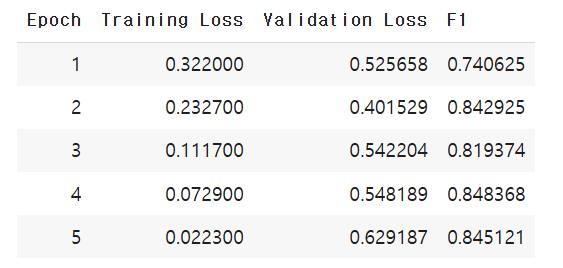

In [ ]:
# 7. 최적의 파라미터로 학습 설정
# 최적의 하이퍼파라미터를 찾은 후, training_args를 설정합니다.
training_args = TrainingArguments(
    output_dir='/content',
    num_train_epochs=10,  # 에포크 수 고정
    per_device_train_batch_size=64,  # 배치 크기 고정
    learning_rate=5.3410887999666175e-05,  # 최적화된 학습률
    weight_decay=0.009899950191395234,  # 최적화된 weight decay
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='/content',
    logging_steps=10,
    fp16=True,
    disable_tqdm=False,
    load_best_model_at_end=True,
    report_to="none"
)

# 최적의 파라미터로 Trainer 구성
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

trainer7 = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # 전체 학습 데이터로 평가
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# CPU 사용량 및 속도 측정
measure_cpu_usage_and_time(trainer7.train)

Epoch,Training Loss,Validation Loss,F1
1,0.402800,0.450714,0.790603
2,0.334200,0.463001,0.790459
3,0.167200,0.549962,0.828495
4,0.164500,0.515599,0.815051
5,0.059300,0.776408,0.807402
6,0.062600,0.855749,0.812094
7,0.035200,0.873747,0.823158
8,0.024900,0.953348,0.810288
9,0.006200,0.966888,0.808933
10,0.006000,0.928714,0.820014


Elapsed Time: 1033.69 seconds
Average CPU Usage: 16.00%


In [ ]:
# 모델 저장
joblib.dump(trainer7, '/content/gdrive/MyDrive/NSMC_0.8.pkl')

print("모델이 저장되었습니다.")

모델이 저장되었습니다.


In [ ]:
# 8. 저장된 모델로 테스트 데이터 예측 및 결과 저장
# 저장된 모델 불러오기

loaded_model = joblib.load('/content/gdrive/MyDrive/NSMC_0.8.pkl')

# 불러온 모델을 사용하여 예측 수행
predictions7 = loaded_model.predict(test_dataset)

test_predictions7 = np.argmax(predictions7.predictions, axis=1)
decoded_test_predictions7 = label_encoder.inverse_transform(test_predictions7)

In [ ]:
test["category_prediction"] = decoded_test_predictions7

selected_columns7 = test[['text', 'category_prediction']]
selected_columns7.head(10)

,text,category_prediction
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,폴리스스토리 시리즈는 뉴까지 버릴께 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
5,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,완전 감동입니다 다시봐도 감동,1
7,개들의 나오나요 나오면 보고 싶음,1
8,내 나이와 같은 영화를 지금 본 나는 감동적이다하지만 훗날 다시보면대사하나하나 그 ...,1
9,영화의 오페라화라고 해야할 작품 극단적 평갈림은 어쩔 수 없는 듯,0


In [ ]:
selected_columns7.to_csv('nsmc_0.8_prediction.csv', encoding='utf-8-sig')

# 평가

In [ ]:
from sklearn.metrics import f1_score

import pandas as pd

df=pd.read_csv('/content/nsmc_0.8_prediction.csv', encoding='utf-8-sig')

df.head(3)

,Unnamed: 0,text,y_pred,y_true
0,0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,1
1,1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1,1
2,2,폴리스스토리 시리즈는 뉴까지 버릴께 하나도 없음 최고,1,1


In [ ]:
df.columns

Index(['Unnamed: 0', 'text', 'y_pred', 'y_true'], dtype='object')

In [ ]:
from sklearn.metrics import classification_report, f1_score

# y_true와 y_pred를 추출
y_true = df['y_true']
y_pred = df['y_pred']

# classification_report를 사용하여 각 클래스별 F1-score 출력
report = classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8728    0.6860    0.7682      1000
           1     0.7414    0.9000    0.8130      1000

    accuracy                         0.7930      2000
   macro avg     0.8071    0.7930    0.7906      2000
weighted avg     0.8071    0.7930    0.7906      2000



# 고정된 파라미터로 재학습

In [20]:
#CPU 측정

import psutil
import time
from transformers import Trainer, TrainingArguments

# CPU 사용량 및 속도 측정 함수
def measure_cpu_usage_and_time(train_function):
    start_time = time.time()  # 시작 시간 기록
    start_cpu = psutil.cpu_percent(interval=None)  # 시작 CPU 사용량

    train_function()  # 학습 함수 호출

    end_time = time.time()  # 종료 시간 기록
    end_cpu = psutil.cpu_percent(interval=None)  # 종료 CPU 사용량

    elapsed_time = end_time - start_time
    avg_cpu_usage = (start_cpu + end_cpu) / 2

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Average CPU Usage: {avg_cpu_usage:.2f}%")

In [21]:
import optuna
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np

# `compute_metrics` 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='macro')  # F1 점수 계산
    return {'eval_f1': f1}  # 'eval_f1' 반환

# Optuna를 활용한 하이퍼파라미터 튜닝
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

In [22]:
# 7. 최적의 파라미터로 학습 설정
# 최적의 하이퍼파라미터를 찾은 후, training_args를 설정합니다.
training_args = TrainingArguments(
    output_dir='/content',
    num_train_epochs=10,  # 에포크 수 고정
    per_device_train_batch_size=64,  # 배치 크기 고정
    learning_rate=5.0e-05,  # 최적화된 학습률
    weight_decay=0.01,  # 최적화된 weight decay
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='/content',
    logging_steps=10,
    fp16=True,
    disable_tqdm=False,
    load_best_model_at_end=True,
    report_to="none"
)

# 최적의 파라미터로 Trainer 구성
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

trainer7 = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # 전체 학습 데이터로 평가
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# CPU 사용량 및 속도 측정
measure_cpu_usage_and_time(trainer7.train)

Epoch,Training Loss,Validation Loss,F1
1,0.393000,0.433994,0.798510
2,0.269700,0.394714,0.827294
3,0.197400,0.498075,0.821663
4,0.081100,0.620905,0.836402
5,0.057300,0.699318,0.830500
6,0.068600,0.685226,0.805242
7,0.044800,0.794631,0.817364
8,0.054100,0.782677,0.833123
9,0.012600,0.835629,0.828008
10,0.003200,0.812049,0.830657


Elapsed Time: 976.35 seconds
Average CPU Usage: 17.95%


In [24]:
# 모델 저장
joblib.dump(trainer7, '/content/gdrive/MyDrive/NSMC_0.8.pkl')

print("모델이 저장되었습니다.")

모델이 저장되었습니다.


In [25]:
# 8. 저장된 모델로 테스트 데이터 예측 및 결과 저장
# 저장된 모델 불러오기

loaded_model = joblib.load('/content/gdrive/MyDrive/NSMC_0.8.pkl')

# 불러온 모델을 사용하여 예측 수행
predictions7 = loaded_model.predict(test_dataset)

test_predictions7 = np.argmax(predictions7.predictions, axis=1)
decoded_test_predictions7 = label_encoder.inverse_transform(test_predictions7)

In [26]:
test["category_prediction"] = decoded_test_predictions7

selected_columns7 = test[['text', 'category_prediction']]
selected_columns7.head(10)

,text,category_prediction
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,폴리스스토리 시리즈는 뉴까지 버릴께 하나도 없음 최고,0
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
5,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,완전 감동입니다 다시봐도 감동,1
7,개들의 나오나요 나오면 보고 싶음,1
8,내 나이와 같은 영화를 지금 본 나는 감동적이다하지만 훗날 다시보면대사하나하나 그 ...,1
9,영화의 오페라화라고 해야할 작품 극단적 평갈림은 어쩔 수 없는 듯,0


In [27]:
selected_columns7.to_csv('nsmc_0.8_prediction.csv', encoding='utf-8-sig')

# 평가

In [28]:
from sklearn.metrics import f1_score

import pandas as pd

df=pd.read_csv('/content/nsmc_0.8_prediction.csv', encoding='utf-8-sig')

df.head(3)

,Unnamed: 0,text,y_pred,y_true
0,0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,1
1,1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1,1
2,2,폴리스스토리 시리즈는 뉴까지 버릴께 하나도 없음 최고,0,1


In [29]:
from sklearn.metrics import classification_report, f1_score

# y_true와 y_pred를 추출
y_true = df['y_true']
y_pred = df['y_pred']

# classification_report를 사용하여 각 클래스별 F1-score 출력
report = classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8518    0.7930    0.8213      1000
           1     0.8064    0.8620    0.8333      1000

    accuracy                         0.8275      2000
   macro avg     0.8291    0.8275    0.8273      2000
weighted avg     0.8291    0.8275    0.8273      2000

